# Credit Card Default Classification Project



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

%matplotlib inline

#pd.options.display.max_columns = None

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

## Import Data

In [2]:
df = pd.read_csv('DATA/training_data.csv',  index_col = 0)
df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,...,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,...,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


# Data Cleaning & EDA

It seems like there's a row that's supposed to be the header.

In [3]:
df = df.rename(columns = df.loc['ID'])
df = df.drop([df.index[0], 'ID'])
df = df.rename(columns = {'default payment next month': 'Y'})

In [4]:
#df.info()

They are still all objects. Let's take a look at each of their unique values, if they don't have to be objects, I'll convert them.

In [5]:
#df.describe()

In [6]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y'],
      dtype='object')

In [7]:
categorical = ['SEX', 'EDUCATION', 'MARRIAGE']
for c in df.columns:
    if c not in categorical: 
        df[c] = pd.to_numeric(df[c])

#for c in df.columns[0:5]:
#    print (f"{c}: {df[c].unique()}")

### Default (Y)

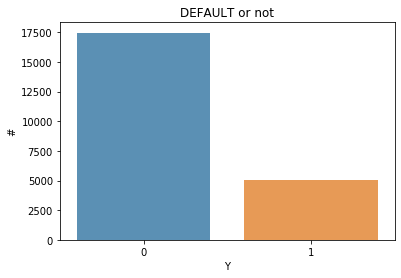

In [8]:
sns.countplot(df['Y'], alpha =.80)
plt.title('DEFAULT or not')
plt.ylabel('#')
plt.show()

### Credit Limit

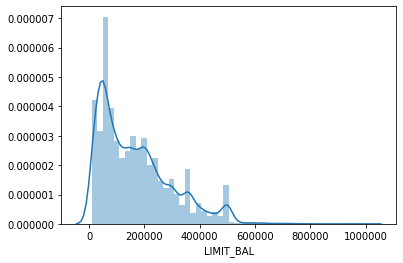

In [9]:
sns.distplot(df.LIMIT_BAL)

Some people seems to have very high credit limit, but nothing look abnormal.

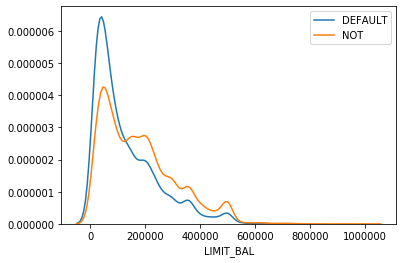

In [10]:
sns.distplot(df[df.Y == 1]['LIMIT_BAL'], hist = False, label='DEFAULT')
sns.distplot(df[df.Y == 0]['LIMIT_BAL'], hist = False, label='NOT')

plt.legend()
plt.show()

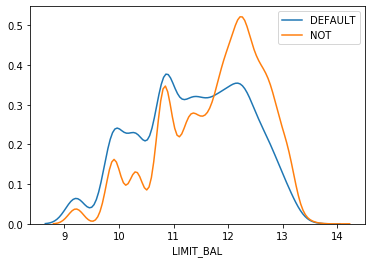

In [11]:
# try normalizing
sns.distplot(np.log(df[df.Y == 1]['LIMIT_BAL']), hist = False, label='DEFAULT')
sns.distplot(np.log(df[df.Y == 0]['LIMIT_BAL']), hist = False, label='NOT')

plt.legend()
plt.show()

### SEX

In [12]:
df.SEX.value_counts()

2    13571
1     8927
Name: SEX, dtype: int64

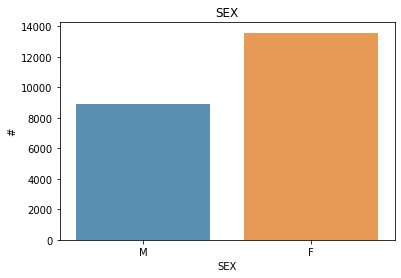

In [13]:
sns.countplot(df['SEX'], alpha =.80)
plt.title('SEX')
plt.xticks([0, 1], ['M', 'F'])
plt.ylabel('#')
plt.show()

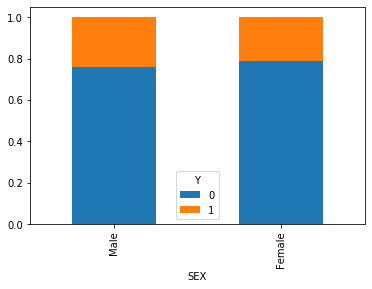

In [14]:
tmp = df.groupby(['SEX']).Y.value_counts(normalize = True).unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

Data is a little skewed towards females.

### Education

In [15]:
df.EDUCATION.value_counts()

2    10516
1     7918
3     3713
5      208
4       90
6       42
0       11
Name: EDUCATION, dtype: int64

There are unknown values above 4. We can roughly assume that higher education is linked to higher credit limit. Let's see if this matches up with the number system. 

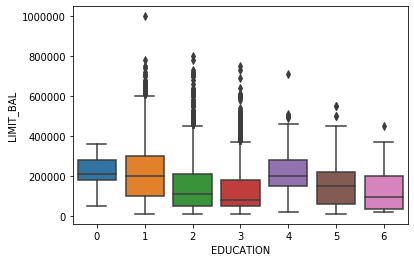

In [16]:
sns.boxplot(df.EDUCATION, df.LIMIT_BAL)

Okay, we cannot treat this as an ordinal group. We will treat as categorical.

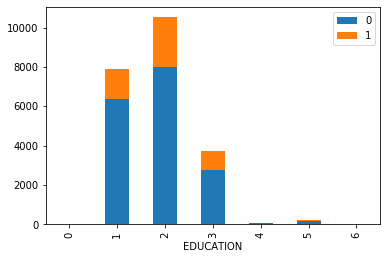

In [17]:
tmp = df.groupby(['EDUCATION']).Y.value_counts().unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

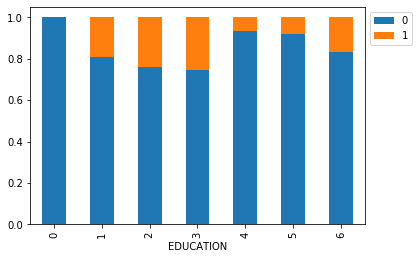

In [18]:
tmp = df.groupby(['EDUCATION']).Y.value_counts(normalize = True).unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

### MARRIAGE

In [19]:
df.MARRIAGE.value_counts()

2    12025
1    10195
3      234
0       44
Name: MARRIAGE, dtype: int64

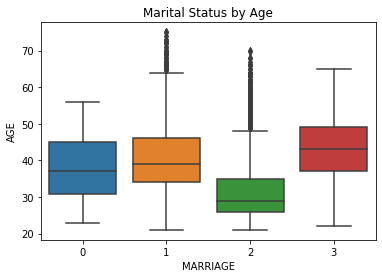

In [20]:
sns.boxplot(x = 'MARRIAGE', y = 'AGE', data = df).set_title('Marital Status by Age')
plt.show()

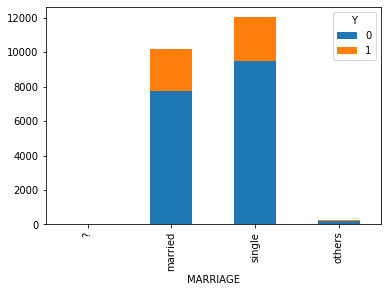

In [21]:
tmp = df.groupby(['MARRIAGE']).Y.value_counts().unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.xticks([0, 1, 2, 3], ['?', 'married', 'single', 'others'])
plt.show()

I'm guessing 0 values are ones we don't have the information for but I'm going to leave as it for now.

In [22]:
#df.MARRIAGE = df.MARRIAGE.replace('3', '0')

### Age

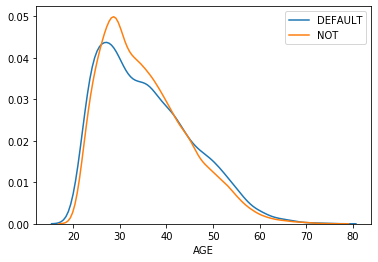

In [23]:
sns.distplot(df[df.Y == 1]['AGE'], hist = False, label='DEFAULT')
sns.distplot(df[df.Y == 0]['AGE'], hist = False, label='NOT')

plt.legend()
plt.show()

# Baseline Model
I'll create a basline logistic regression model using demographics only. 

In [24]:
def fit_logreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    logreg = LogisticRegression(class_weight = 'balanced', max_iter = 10000)
    logreg.fit(X_train, y_train)    
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)
    f1_train = round(f1_score(y_train, y_pred_train), 3)
    f1_test = round(f1_score(y_test, y_pred_test), 3)
    print(f"F1_train: {f1_train}")
    print(f"F1_test: {f1_test}")
    print(f"Test Accuracy: {round(accuracy_score(y_test, y_pred_test), 3)}")
    print(f"Test AUC: {round(roc_auc_score(y_test, y_pred_test), 3)}")

    return logreg, f1_train, f1_test

In [25]:
y = df['Y']
X = pd.get_dummies(df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']])

In [26]:
def corr_high(df):
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.7) & (corr_df['v1'] != corr_df['v2'])].sort_values(
        by = 'c', ascending = False)

corr_high(X)[1]

,v1,v2,c
33,SEX_1,SEX_2,1.000000
47,SEX_2,SEX_1,1.000000
193,MARRIAGE_1,MARRIAGE_2,0.975428
207,MARRIAGE_2,MARRIAGE_1,0.975428


In [27]:
X = X.drop(['SEX_2', 'MARRIAGE_1'], axis = 1)

In [28]:
lr = fit_logreg(X, y)

# Keeping a log of all models fitted

models= {'only_demographics_logreg': (lr[1], lr[2])}

F1_train: 0.0
F1_test: 0.0
Test Accuracy: 0.771
Test AUC: 0.5


In [29]:
df = pd.get_dummies(df)

### History of past payment
PAY0 ~ 6 are past payment status backwards (from Sept ~ April).  
Repayment status measurement scale is...  
-1: paid ontime  
1: delayed for one month  
2: delayed for 2 months  ...  
8: delayed for 8 months  
9: delayed for nine + months  

I want to first see if there are no values I don't understand.

In [30]:
pay_hist_names =[c for c in df if c.startswith('PAY')][0:6]

In [38]:
[df[x].unique() for x in pay_hist_names]

[array([-1, -2,  0,  2,  1,  3,  8,  4,  6,  5,  7], dtype=int64),
 array([-1, -2,  0,  2,  3,  4,  7,  5,  1,  8,  6], dtype=int64),
 array([-1, -2,  0,  2,  3,  4,  6,  5,  7,  8,  1], dtype=int64),
 array([-1, -2,  0,  2,  4,  5,  3,  7,  6,  8,  1], dtype=int64),
 array([-1, -2,  0,  2,  4,  3,  7,  5,  6,  8], dtype=int64),
 array([-1, -2,  0,  2,  4,  3,  7,  6,  8,  5], dtype=int64)]

Okay, there are 0 and -2, which are not the values we are supposed to have. I'll try to sample someone and see if we can figure it out.

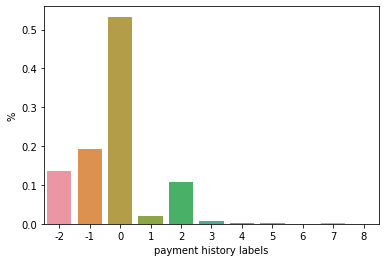

In [39]:
Y = pd.melt(df[pay_hist_names], value_vars = pay_hist_names).value.value_counts(normalize = True)
X = Y.index

sns.barplot(X, Y)
plt.xlabel('payment history labels')
plt.ylabel('%')
plt.show()

I want to assume that 0 is on time payment. But I'll feed in as categorical for now.  
On the other hand, these measures may highly correlating with others, since they can be accumulating balance.  
So we need a better measure for these that are not time sensative. We will add some measures later and remove these.  

In [40]:
#corr_high(df)[1]

### Amount of Billing Statement & Payment
BILL_AMT1 ~ 6 are also backward statement from September ~ April.  
PAY_AMT1~6 are previous payment from Sept ~ April.  

In [41]:
bill_amt_names = [c for c in df if c.startswith('BILL_AMT')]
pay_amt_names = [c for c in df if c.startswith('PAY_AMT')]

In [42]:
# making a dataframe so I can plot performance each month
tmp2 = pd.melt(df[bill_amt_names].reset_index(), id_vars = 'index', value_vars=bill_amt_names, value_name='bill_amount')
tmp2 = tmp2.replace(tmp2.variable.unique(), [1, 2, 3, 4, 5, 6])

tmp3 = pd.melt(df[pay_amt_names].reset_index(), id_vars = 'index', value_vars=pay_amt_names, value_name='pay_amount')
tmp3 = tmp3.replace(tmp3.variable.unique(), [1, 2, 3, 4, 5, 6])

tmp = tmp2.merge(tmp3)

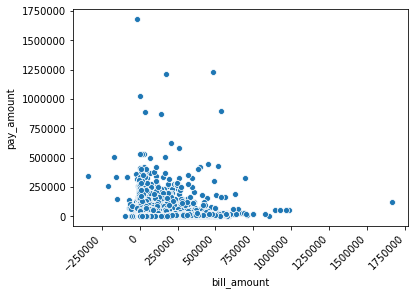

In [43]:
sns.scatterplot(x = 'bill_amount', y = 'pay_amount', data = tmp)
plt.xticks(rotation=45, ha='right')
plt.show()

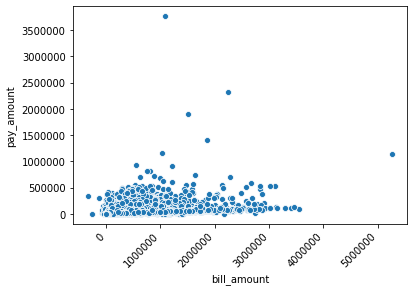

In [44]:
tmp_b = tmp.groupby('index').sum()
sns.scatterplot(x = 'bill_amount', y = 'pay_amount', data = tmp_b)
plt.xticks(rotation=45, ha='right')
plt.show()

In [45]:
#tmp[tmp['index'] == tmp_b[tmp_b['pay_amount'] > 3500000].index[0]]
#tmp[tmp['index'] == tmp_b[tmp_b['bill_amount'] > 5000000].index[0]]

Some outliers, but I have no evidence to delete them.

### Feature Engineering

#### Payment History
Instead of having each month record, I'll add the number of time for each category. 

In [46]:
payment_hist = pd.melt(df.reset_index(), id_vars = 'index', value_vars=pay_hist_names).groupby(['index', 'value']).count().unstack()
payment_hist = payment_hist.fillna(0)
payment_hist.columns = ['pay_hist_n2', 'pay_hist_n1', 'pay_hist_0', 'pay_hist_1', 'pay_hist_2', 'pay_hist_3', 'pay_hist_4', 
                       'pay_hist_5', 'pay_hist_6', 'pay_hist_7', 'pay_hist_8']

In [47]:
df = df.join(payment_hist)
cols_to_drop = pay_hist_names

#### Add the Balance Info (at the end of the month)
I'll remove this later.

In [48]:
for i in range(1, 7):
    df[f"BAL_{i}"] = df[f"BILL_AMT{i}"] - df[f"PAY_AMT{i}"]

In [49]:
cols_to_drop = cols_to_drop + bill_amt_names + [c for c in df if c.startswith("BAL_")]

#### Add the cumulative change of balance

In [50]:
for i in [6, 5, 4, 3, 2]:
    df[f"BAL_change_{i}"] = df[f"BAL_{i}"] - df[f"BAL_{i-1}"]

In [51]:
df["cum_bal_change"] = df[[c for c in df if c.startswith('BAL_change')]].sum(axis = 1)

In [52]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith("BAL_change")]

#### final balance and payment

In [53]:
df['final_balance'] = df['BAL_1']

In [54]:
df['final_payment'] = df['PAY_AMT1']

#### Add N_Default
How often they paid less than minimum.

In [55]:
for i in range(1, 7):
    df[f"DEF_{i}"] = np.where(((df[f"BILL_AMT{i}"] >= 35) & (df[f"PAY_AMT{i}"] < 35)) | 
                              ((df[f"BILL_AMT{i}"] < 35) & (df[f"PAY_AMT{i}"] < df[f"BILL_AMT{i}"])), 1, 0)

In [56]:
df['N_underpayment'] = df[[c for c in df if c.startswith('DEF')]].sum(axis = 1)

In [57]:
cols_to_drop = cols_to_drop + ['DEF_1']

#### Add Over Credit Limit
number of times they spent over the credit limit.

In [58]:
for i in range(1, 7):
    df[f"over_lim_{i}"] = np.where(df[f"BILL_AMT{i}"] > df[f"LIMIT_BAL"], 1, 0)

In [59]:
df["n_over_lim"] = df[[c for c in df if c.startswith('over_lim')]].sum(axis = 1)

In [60]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('over_lim')]

#### Add Percent Use
Percentage of credit limit used

In [61]:
for i in range(1, 7):
    df[f"percent_use_{i}"] = df[f"BILL_AMT{i}"] / df[f"LIMIT_BAL"]
    
df['avg_percent_use'] = df[[c for c in df if c.startswith('percent_use')]].mean(axis = 1)

In [62]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('percent_use')]

#### Add Pattern Change
Add percent of payment to balance then subtract the most recent one from the old one

In [63]:
for i in range(1, 7):
    df[f"percent_paid_{i}"] = np.where(df[f"BILL_AMT{i}"] > 0, df[f"PAY_AMT{i}"] / df[f"BILL_AMT{i}"], 1)
    
df['payment_patter_change'] = df['percent_paid_6'] - df['percent_paid_1']

In [64]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('percent_paid')]

#### Add Average Percent Paid

In [65]:
df['payment_average_p'] = df[[c for c in df if c.startswith('percent_paid')]].mean(axis = 1)

#### Transform to a Log Limit
data was highly right skewed. it'll fit better if we normalize it a bit.

In [66]:
df['ln_limit_bal'] = np.log(df['LIMIT_BAL'])

In [67]:
cols_to_drop = cols_to_drop + ['LIMIT_BAL']

### Plot everything
Let's take a look at relationship between new variables and target. 

In [88]:
from sklearn.preprocessing import StandardScaler
y = df['Y'].values
X = df.drop(['Y'] + cols_to_drop, axis = 1)

scaler = StandardScaler()
scaler.fit(X)
X1 = pd.DataFrame(scaler.transform(X), columns= X.columns)
X1['Y'] = y

In [ ]:
for c in X1.columns:
    
    sns.distplot(X1[X1.Y == 1][c], hist = False, label='DEFAULT')
    sns.distplot(X1[X1.Y == 0][c], hist = False, label='NOT')

    plt.legend()
    plt.show()

### Fit everything

In [68]:
y = df['Y']
X = df.drop(['Y'], axis = 1)
lr1 = fit_logreg(X, y)

models['after_feat_eng'] = (lr1[1], lr1[2])

F1_train: 0.418
F1_test: 0.431
Test Accuracy: 0.553
Test AUC: 0.618


### Fit all after manually dropping old features

In [69]:
y = df['Y']
X = df.drop(['Y'] + cols_to_drop, axis = 1)
lr2 = fit_logreg(X, y)

models['removing_old_feats'] = (lr1[1], lr1[2])

F1_train: 0.468
F1_test: 0.487
Test Accuracy: 0.714
Test AUC: 0.671


Much better F1 and accuracy, but it's still useless.

### Add Polynomials
Find the most meaningful polynomials and add.

In [84]:
#from sklearn.preprocessing import PolynomialFeatures

#X = df.drop('Y', axis = 1)

#polys = pd.DataFrame(columns = ['col', 'degree', 'f1'])
#logreg = LogisticRegression(class_weight = 'balanced', max_iter = 10000)
#cv = KFold(n_splits = 5, shuffle = True, random_state = 2)
#thresh = np.mean(cross_val_score(logreg, X, y, scoring = 'f1', cv = cv))
print(thresh)

i = 0
for c in X.columns:
    i += 1
    print(i, '/', len(X.columns))
    for deg in [2, 3, 4]: 
        X2 = X.copy()
        poly = PolynomialFeatures(deg, include_bias = False)
        X2[c] = poly.fit_transform(X2[[c]])
        score = np.mean(cross_val_score(logreg, X2, y, scoring = 'f1', cv = cv))
        if score > thresh: 
            print(c, deg, score)
            polys.loc[len(polys)] = [c, deg, f1]


0.4200975495335234
1 / 88
2 / 88
3 / 88
4 / 88
5 / 88
6 / 88
7 / 88
8 / 88
9 / 88
10 / 88
11 / 88
12 / 88
13 / 88
14 / 88
15 / 88
16 / 88
17 / 88
18 / 88
19 / 88
20 / 88
21 / 88
22 / 88
23 / 88
24 / 88
25 / 88
26 / 88
27 / 88
28 / 88
29 / 88
30 / 88
31 / 88
32 / 88
33 / 88
34 / 88
35 / 88
36 / 88
37 / 88


,col,degree,f1


### Add Interaction
Find the most meaningful interactions and add.

In [85]:
from itertools import combinations
train_test_splitrn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def add_interaction(X, y): 
    allpairs = list(combinations(X.columns, 2))

    interactions = pd.DataFrame(columns = ['pair', 'f1'])
    logreg = LogisticRegression(class_weight = 'balanced', max_iter = 5000)
    cv = KFold(n_splits = 3, shuffle = True, random_state = 2)
    thresh = np.mean(cross_val_score(logreg, X, y, scoring = 'f1', cv = cv))
    print(thresh)
    i = 0
    for pair in allpairs:
        i += 1
        X['interaction'] = X[pair[0]] * X[pair[1]]
        score = np.mean(cross_val_score(logreg, X, y, scoring = 'f1', cv = cv))
        if score > thresh: 
            print(i, '/', len(allpairs), ': ', pair, ': ', score)
            interactions.loc[len(interactions)] = [pair, score]
    return interactions

interactions = add_interaction(X, y)

0.42071015811687423
2 / 3828 :  ('LIMIT_BAL', 'PAY_0') :  0.4472029382146612
3 / 3828 :  ('LIMIT_BAL', 'PAY_2') :  0.4303270425919388
4 / 3828 :  ('LIMIT_BAL', 'PAY_3') :  0.4262544380668638
5 / 3828 :  ('LIMIT_BAL', 'PAY_4') :  0.4247234861268497
6 / 3828 :  ('LIMIT_BAL', 'PAY_5') :  0.4210958283161929
7 / 3828 :  ('LIMIT_BAL', 'PAY_6') :  0.4226029532209125
20 / 3828 :  ('LIMIT_BAL', 'SEX_1') :  0.42179478983186386
21 / 3828 :  ('LIMIT_BAL', 'SEX_2') :  0.42163346621284675
22 / 3828 :  ('LIMIT_BAL', 'EDUCATION_0') :  0.42085817699587497
23 / 3828 :  ('LIMIT_BAL', 'EDUCATION_1') :  0.42121196534298383
25 / 3828 :  ('LIMIT_BAL', 'EDUCATION_3') :  0.4211522989551682
27 / 3828 :  ('LIMIT_BAL', 'EDUCATION_5') :  0.4216844098684869
28 / 3828 :  ('LIMIT_BAL', 'EDUCATION_6') :  0.42083244452884766
29 / 3828 :  ('LIMIT_BAL', 'MARRIAGE_0') :  0.4211259190470413
30 / 3828 :  ('LIMIT_BAL', 'MARRIAGE_1') :  0.42132215511206716
31 / 3828 :  ('LIMIT_BAL', 'MARRIAGE_2') :  0.42190871281973585
35 / 3

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


191 / 3828 :  ('PAY_0', 'SEX_1') :  0.449659842899578
192 / 3828 :  ('PAY_0', 'SEX_2') :  0.4507840170538792
193 / 3828 :  ('PAY_0', 'EDUCATION_0') :  0.4207521127985843
194 / 3828 :  ('PAY_0', 'EDUCATION_1') :  0.44851092963589956
195 / 3828 :  ('PAY_0', 'EDUCATION_2') :  0.42074760091584745
196 / 3828 :  ('PAY_0', 'EDUCATION_3') :  0.42071090547667006
197 / 3828 :  ('PAY_0', 'EDUCATION_4') :  0.42075096252395755
198 / 3828 :  ('PAY_0', 'EDUCATION_5') :  0.42082204831818415
200 / 3828 :  ('PAY_0', 'MARRIAGE_0') :  0.4207261543458281
201 / 3828 :  ('PAY_0', 'MARRIAGE_1') :  0.4216347701437368
204 / 3828 :  ('PAY_0', 'pay_hist_n2') :  0.4209376458439687
206 / 3828 :  ('PAY_0', 'pay_hist_0') :  0.42755474453553016
207 / 3828 :  ('PAY_0', 'pay_hist_1') :  0.42075096252395755
208 / 3828 :  ('PAY_0', 'pay_hist_2') :  0.4534137579024897
210 / 3828 :  ('PAY_0', 'pay_hist_4') :  0.4207691856792651
211 / 3828 :  ('PAY_0', 'pay_hist_5') :  0.420722792737718
213 / 3828 :  ('PAY_0', 'pay_hist_7') 

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


423 / 3828 :  ('PAY_3', 'payment_patter_change') :  0.4674097212226485
424 / 3828 :  ('PAY_3', 'payment_average_p') :  0.4208835950076195
425 / 3828 :  ('PAY_3', 'ln_limit_bal') :  0.43192268543255535
426 / 3828 :  ('PAY_4', 'PAY_5') :  0.421713209538483
427 / 3828 :  ('PAY_4', 'PAY_6') :  0.4209339375210681
428 / 3828 :  ('PAY_4', 'BILL_AMT1') :  0.42971211527283676
430 / 3828 :  ('PAY_4', 'BILL_AMT3') :  0.4337832891911328
431 / 3828 :  ('PAY_4', 'BILL_AMT4') :  0.4348266786005688
432 / 3828 :  ('PAY_4', 'BILL_AMT5') :  0.4337887612312166
433 / 3828 :  ('PAY_4', 'BILL_AMT6') :  0.43403904351796135
434 / 3828 :  ('PAY_4', 'PAY_AMT1') :  0.42596586908726025
435 / 3828 :  ('PAY_4', 'PAY_AMT2') :  0.42418304119947026
437 / 3828 :  ('PAY_4', 'PAY_AMT4') :  0.42250014880743564
438 / 3828 :  ('PAY_4', 'PAY_AMT5') :  0.42165528036934236
439 / 3828 :  ('PAY_4', 'PAY_AMT6') :  0.42185007306207956
440 / 3828 :  ('PAY_4', 'SEX_1') :  0.4207456832315423
441 / 3828 :  ('PAY_4', 'SEX_2') :  0.42072

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


541 / 3828 :  ('PAY_5', 'pay_hist_5') :  0.445565959572153
542 / 3828 :  ('PAY_5', 'pay_hist_6') :  0.4208001931188359
543 / 3828 :  ('PAY_5', 'pay_hist_7') :  0.42077652663860804
545 / 3828 :  ('PAY_5', 'BAL_1') :  0.42770308433979115
546 / 3828 :  ('PAY_5', 'BAL_2') :  0.427630634598191
548 / 3828 :  ('PAY_5', 'BAL_4') :  0.4554603152275414
549 / 3828 :  ('PAY_5', 'BAL_5') :  0.43070035391927813
550 / 3828 :  ('PAY_5', 'BAL_6') :  0.42962705244570837
551 / 3828 :  ('PAY_5', 'BAL_change_6') :  0.42107854724917165
552 / 3828 :  ('PAY_5', 'BAL_change_5') :  0.4207884854194008
553 / 3828 :  ('PAY_5', 'BAL_change_4') :  0.4209391958256958
555 / 3828 :  ('PAY_5', 'BAL_change_2') :  0.42172317767792616
556 / 3828 :  ('PAY_5', 'cum_bal_change') :  0.4212502626246817
557 / 3828 :  ('PAY_5', 'final_balance') :  0.42770308433979115
558 / 3828 :  ('PAY_5', 'final_payment') :  0.4246764090994776
559 / 3828 :  ('PAY_5', 'DEF_1') :  0.4208020317868486
561 / 3828 :  ('PAY_5', 'DEF_3') :  0.420866308

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


995 / 3828 :  ('BILL_AMT5', 'MARRIAGE_0') :  0.443138422657108
997 / 3828 :  ('BILL_AMT5', 'MARRIAGE_2') :  0.4224178261697507
998 / 3828 :  ('BILL_AMT5', 'MARRIAGE_3') :  0.42086395334703086
999 / 3828 :  ('BILL_AMT5', 'pay_hist_n2') :  0.42074726078777075
1001 / 3828 :  ('BILL_AMT5', 'pay_hist_0') :  0.46263265104869483
1002 / 3828 :  ('BILL_AMT5', 'pay_hist_1') :  0.4215515999515955
1003 / 3828 :  ('BILL_AMT5', 'pay_hist_2') :  0.4702726594918773
1004 / 3828 :  ('BILL_AMT5', 'pay_hist_3') :  0.4246826999740163
1005 / 3828 :  ('BILL_AMT5', 'pay_hist_4') :  0.4216550025520665
1006 / 3828 :  ('BILL_AMT5', 'pay_hist_5') :  0.42120674032425914
1007 / 3828 :  ('BILL_AMT5', 'pay_hist_6') :  0.4212659042049413
1008 / 3828 :  ('BILL_AMT5', 'pay_hist_7') :  0.4211626700296323
1009 / 3828 :  ('BILL_AMT5', 'pay_hist_8') :  0.42813710046233183
1024 / 3828 :  ('BILL_AMT5', 'DEF_1') :  0.4257672184259465
1025 / 3828 :  ('BILL_AMT5', 'DEF_2') :  0.42590820837892557
1026 / 3828 :  ('BILL_AMT5', 'DEF

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1225 / 3828 :  ('PAY_AMT2', 'pay_hist_5') :  0.4530011406353868
1227 / 3828 :  ('PAY_AMT2', 'pay_hist_7') :  0.42113453523093947
1228 / 3828 :  ('PAY_AMT2', 'pay_hist_8') :  0.42082501845486453
1243 / 3828 :  ('PAY_AMT2', 'DEF_1') :  0.4233325864873165
1245 / 3828 :  ('PAY_AMT2', 'DEF_3') :  0.42311368673762334
1246 / 3828 :  ('PAY_AMT2', 'DEF_4') :  0.4220468283537102
1247 / 3828 :  ('PAY_AMT2', 'DEF_5') :  0.4211826318143345
1248 / 3828 :  ('PAY_AMT2', 'DEF_6') :  0.42135986179489465
1249 / 3828 :  ('PAY_AMT2', 'N_underpayment') :  0.425191656810265
1250 / 3828 :  ('PAY_AMT2', 'over_lim_1') :  0.4216840348660987
1251 / 3828 :  ('PAY_AMT2', 'over_lim_2') :  0.4220407947739369
1252 / 3828 :  ('PAY_AMT2', 'over_lim_3') :  0.4218187837884637
1253 / 3828 :  ('PAY_AMT2', 'over_lim_4') :  0.4213034182029098
1255 / 3828 :  ('PAY_AMT2', 'over_lim_6') :  0.4232757999527821
1256 / 3828 :  ('PAY_AMT2', 'n_over_lim') :  0.4220553134832807
1257 / 3828 :  ('PAY_AMT2', 'percent_use_1') :  0.42226040

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1331 / 3828 :  ('PAY_AMT3', 'percent_use_4') :  0.4498362130370366
1332 / 3828 :  ('PAY_AMT3', 'percent_use_5') :  0.42260065411623793
1333 / 3828 :  ('PAY_AMT3', 'percent_use_6') :  0.42218228782222367
1334 / 3828 :  ('PAY_AMT3', 'avg_percent_use') :  0.42255178598140625
1335 / 3828 :  ('PAY_AMT3', 'percent_paid_1') :  0.42084697288899076
1336 / 3828 :  ('PAY_AMT3', 'percent_paid_2') :  0.4208334085181404
1338 / 3828 :  ('PAY_AMT3', 'percent_paid_4') :  0.44952882855497805
1339 / 3828 :  ('PAY_AMT3', 'percent_paid_5') :  0.4209894733878519
1340 / 3828 :  ('PAY_AMT3', 'percent_paid_6') :  0.4207987976196792
1343 / 3828 :  ('PAY_AMT3', 'ln_limit_bal') :  0.42101709757860944
1346 / 3828 :  ('PAY_AMT4', 'SEX_1') :  0.45030452319432906
1347 / 3828 :  ('PAY_AMT4', 'SEX_2') :  0.4219409440327054
1348 / 3828 :  ('PAY_AMT4', 'EDUCATION_0') :  0.420836054273348
1349 / 3828 :  ('PAY_AMT4', 'EDUCATION_1') :  0.42071629070787764
1351 / 3828 :  ('PAY_AMT4', 'EDUCATION_3') :  0.42549359635442613
135

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1366 / 3828 :  ('PAY_AMT4', 'pay_hist_5') :  0.450229493227351
1368 / 3828 :  ('PAY_AMT4', 'pay_hist_7') :  0.42082386781801845
1369 / 3828 :  ('PAY_AMT4', 'pay_hist_8') :  0.42089836958743554
1384 / 3828 :  ('PAY_AMT4', 'DEF_1') :  0.4213032522832379
1385 / 3828 :  ('PAY_AMT4', 'DEF_2') :  0.4227644954193024
1386 / 3828 :  ('PAY_AMT4', 'DEF_3') :  0.42197379214704783
1387 / 3828 :  ('PAY_AMT4', 'DEF_4') :  0.420728051618201
1388 / 3828 :  ('PAY_AMT4', 'DEF_5') :  0.4213592420409868
1389 / 3828 :  ('PAY_AMT4', 'DEF_6') :  0.421398707058467
1390 / 3828 :  ('PAY_AMT4', 'N_underpayment') :  0.42432885625296607
1391 / 3828 :  ('PAY_AMT4', 'over_lim_1') :  0.4238630570164492
1392 / 3828 :  ('PAY_AMT4', 'over_lim_2') :  0.4234738870123926
1393 / 3828 :  ('PAY_AMT4', 'over_lim_3') :  0.42273232937710015
1394 / 3828 :  ('PAY_AMT4', 'over_lim_4') :  0.42173096636949586
1395 / 3828 :  ('PAY_AMT4', 'over_lim_5') :  0.421685886770545
1396 / 3828 :  ('PAY_AMT4', 'over_lim_6') :  0.42157127946339656

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1479 / 3828 :  ('PAY_AMT5', 'percent_paid_6') :  0.43665895383219183
1481 / 3828 :  ('PAY_AMT5', 'payment_average_p') :  0.4209773358839964
1482 / 3828 :  ('PAY_AMT5', 'ln_limit_bal') :  0.42222250842643216
1483 / 3828 :  ('PAY_AMT6', 'SEX_1') :  0.42135635421724843
1484 / 3828 :  ('PAY_AMT6', 'SEX_2') :  0.4214213821593902
1485 / 3828 :  ('PAY_AMT6', 'EDUCATION_0') :  0.4208599331432851
1487 / 3828 :  ('PAY_AMT6', 'EDUCATION_2') :  0.4210145615453294
1489 / 3828 :  ('PAY_AMT6', 'EDUCATION_4') :  0.4209655007485573
1492 / 3828 :  ('PAY_AMT6', 'MARRIAGE_0') :  0.4220695714191174
1493 / 3828 :  ('PAY_AMT6', 'MARRIAGE_1') :  0.4212532377980669
1494 / 3828 :  ('PAY_AMT6', 'MARRIAGE_2') :  0.42116348439495527
1495 / 3828 :  ('PAY_AMT6', 'MARRIAGE_3') :  0.4207555074922073
1498 / 3828 :  ('PAY_AMT6', 'pay_hist_0') :  0.42343094885600463
1499 / 3828 :  ('PAY_AMT6', 'pay_hist_1') :  0.42090608108615807
1500 / 3828 :  ('PAY_AMT6', 'pay_hist_2') :  0.4370047986999896
1502 / 3828 :  ('PAY_AMT6', 

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1620 / 3828 :  ('SEX_2', 'EDUCATION_2') :  0.44206078183927566
1621 / 3828 :  ('SEX_2', 'EDUCATION_3') :  0.4208204849683643
1623 / 3828 :  ('SEX_2', 'EDUCATION_5') :  0.44991813895496097
1624 / 3828 :  ('SEX_2', 'EDUCATION_6') :  0.42178011101592744
1626 / 3828 :  ('SEX_2', 'MARRIAGE_1') :  0.420728051618201
1627 / 3828 :  ('SEX_2', 'MARRIAGE_2') :  0.4207517098837532
1628 / 3828 :  ('SEX_2', 'MARRIAGE_3') :  0.4472323831793708
1631 / 3828 :  ('SEX_2', 'pay_hist_0') :  0.4241231387557429
1633 / 3828 :  ('SEX_2', 'pay_hist_2') :  0.4211300688965732
1635 / 3828 :  ('SEX_2', 'pay_hist_4') :  0.4207757792788122
1640 / 3828 :  ('SEX_2', 'BAL_1') :  0.42219958344847425
1641 / 3828 :  ('SEX_2', 'BAL_2') :  0.42212073856659105
1642 / 3828 :  ('SEX_2', 'BAL_3') :  0.4219744138462204
1643 / 3828 :  ('SEX_2', 'BAL_4') :  0.4229072390800716
1644 / 3828 :  ('SEX_2', 'BAL_5') :  0.42254477746971775


C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1645 / 3828 :  ('SEX_2', 'BAL_6') :  0.43673108725568666
1647 / 3828 :  ('SEX_2', 'BAL_change_5') :  0.4426088001578227
1648 / 3828 :  ('SEX_2', 'BAL_change_4') :  0.4214831841098494
1651 / 3828 :  ('SEX_2', 'cum_bal_change') :  0.4209245622717128
1652 / 3828 :  ('SEX_2', 'final_balance') :  0.42219958344847425
1653 / 3828 :  ('SEX_2', 'final_payment') :  0.42110236486254876
1655 / 3828 :  ('SEX_2', 'DEF_2') :  0.42135156477501085
1658 / 3828 :  ('SEX_2', 'DEF_5') :  0.4207265571448037
1661 / 3828 :  ('SEX_2', 'over_lim_1') :  0.4207292183179027
1663 / 3828 :  ('SEX_2', 'over_lim_3') :  0.42072729604372966
1664 / 3828 :  ('SEX_2', 'over_lim_4') :  0.4214688985348058
1665 / 3828 :  ('SEX_2', 'over_lim_5') :  0.43616970746723566
1666 / 3828 :  ('SEX_2', 'over_lim_6') :  0.4207517098837532
1667 / 3828 :  ('SEX_2', 'n_over_lim') :  0.42080060461484087
1668 / 3828 :  ('SEX_2', 'percent_use_1') :  0.42076921082810764
1669 / 3828 :  ('SEX_2', 'percent_use_2') :  0.420726976976977
1670 / 3828 

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1692 / 3828 :  ('EDUCATION_0', 'MARRIAGE_2') :  0.44777432782711185
1693 / 3828 :  ('EDUCATION_0', 'MARRIAGE_3') :  0.4209341447442891
1694 / 3828 :  ('EDUCATION_0', 'pay_hist_n2') :  0.4215182851043234
1695 / 3828 :  ('EDUCATION_0', 'pay_hist_n1') :  0.4207277074194306
1696 / 3828 :  ('EDUCATION_0', 'pay_hist_0') :  0.4207284545330321
1697 / 3828 :  ('EDUCATION_0', 'pay_hist_1') :  0.4208013519746367
1698 / 3828 :  ('EDUCATION_0', 'pay_hist_2') :  0.4207288744899069
1699 / 3828 :  ('EDUCATION_0', 'pay_hist_3') :  0.4209341447442891
1700 / 3828 :  ('EDUCATION_0', 'pay_hist_4') :  0.4209341447442891
1701 / 3828 :  ('EDUCATION_0', 'pay_hist_5') :  0.4209341447442891
1702 / 3828 :  ('EDUCATION_0', 'pay_hist_6') :  0.4209341447442891
1703 / 3828 :  ('EDUCATION_0', 'pay_hist_7') :  0.4209341447442891
1704 / 3828 :  ('EDUCATION_0', 'pay_hist_8') :  0.4209341447442891
1705 / 3828 :  ('EDUCATION_0', 'BAL_1') :  0.4210373614249278


C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1706 / 3828 :  ('EDUCATION_0', 'BAL_2') :  0.44505479391623454
1707 / 3828 :  ('EDUCATION_0', 'BAL_3') :  0.44982229096825427
1708 / 3828 :  ('EDUCATION_0', 'BAL_4') :  0.421552451285194
1709 / 3828 :  ('EDUCATION_0', 'BAL_5') :  0.42188185852565024
1711 / 3828 :  ('EDUCATION_0', 'BAL_change_6') :  0.4427511988686594
1714 / 3828 :  ('EDUCATION_0', 'BAL_change_3') :  0.4214541681486601
1715 / 3828 :  ('EDUCATION_0', 'BAL_change_2') :  0.4213883145584079
1716 / 3828 :  ('EDUCATION_0', 'cum_bal_change') :  0.42132534983295994
1717 / 3828 :  ('EDUCATION_0', 'final_balance') :  0.4210373614249278
1718 / 3828 :  ('EDUCATION_0', 'final_payment') :  0.4207895941218054
1720 / 3828 :  ('EDUCATION_0', 'DEF_2') :  0.4207949329659563
1722 / 3828 :  ('EDUCATION_0', 'DEF_4') :  0.4208657689231365
1723 / 3828 :  ('EDUCATION_0', 'DEF_5') :  0.4209341447442891
1724 / 3828 :  ('EDUCATION_0', 'DEF_6') :  0.42072891453528616
1726 / 3828 :  ('EDUCATION_0', 'over_lim_1') :  0.4209341447442891
1727 / 3828 :  

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1735 / 3828 :  ('EDUCATION_0', 'percent_use_3') :  0.449687509904477
1738 / 3828 :  ('EDUCATION_0', 'percent_use_6') :  0.420728051618201
1740 / 3828 :  ('EDUCATION_0', 'percent_paid_1') :  0.42072729604372966
1741 / 3828 :  ('EDUCATION_0', 'percent_paid_2') :  0.4215510518136198
1743 / 3828 :  ('EDUCATION_0', 'percent_paid_4') :  0.42077537636398105
1746 / 3828 :  ('EDUCATION_0', 'payment_patter_change') :  0.42075056818585166
1748 / 3828 :  ('EDUCATION_0', 'ln_limit_bal') :  0.42080060461484087
1749 / 3828 :  ('EDUCATION_1', 'EDUCATION_2') :  0.4209341447442891
1750 / 3828 :  ('EDUCATION_1', 'EDUCATION_3') :  0.4209341447442891
1751 / 3828 :  ('EDUCATION_1', 'EDUCATION_4') :  0.4209341447442891
1752 / 3828 :  ('EDUCATION_1', 'EDUCATION_5') :  0.4209341447442891
1753 / 3828 :  ('EDUCATION_1', 'EDUCATION_6') :  0.4209341447442891
1754 / 3828 :  ('EDUCATION_1', 'MARRIAGE_0') :  0.42072576858000216
1755 / 3828 :  ('EDUCATION_1', 'MARRIAGE_1') :  0.42075253275545926
1760 / 3828 :  ('EDUCA

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1820 / 3828 :  ('EDUCATION_2', 'MARRIAGE_3') :  0.4485539600566539
1822 / 3828 :  ('EDUCATION_2', 'pay_hist_n1') :  0.4207292183179027
1823 / 3828 :  ('EDUCATION_2', 'pay_hist_0') :  0.4208569779437634
1824 / 3828 :  ('EDUCATION_2', 'pay_hist_1') :  0.42075056818585166
1825 / 3828 :  ('EDUCATION_2', 'pay_hist_2') :  0.4209005518131432
1826 / 3828 :  ('EDUCATION_2', 'pay_hist_3') :  0.42092798449395236
1827 / 3828 :  ('EDUCATION_2', 'pay_hist_4') :  0.42071090547667006
1828 / 3828 :  ('EDUCATION_2', 'pay_hist_5') :  0.4214869261125491
1832 / 3828 :  ('EDUCATION_2', 'BAL_1') :  0.42131912938910965
1833 / 3828 :  ('EDUCATION_2', 'BAL_2') :  0.42193475304457434
1834 / 3828 :  ('EDUCATION_2', 'BAL_3') :  0.42227961589221064
1835 / 3828 :  ('EDUCATION_2', 'BAL_4') :  0.4520166089728164
1836 / 3828 :  ('EDUCATION_2', 'BAL_5') :  0.4215723571465146
1837 / 3828 :  ('EDUCATION_2', 'BAL_6') :  0.4220591304909404
1839 / 3828 :  ('EDUCATION_2', 'BAL_change_5') :  0.42122080427045083
1840 / 3828 :  

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1961 / 3828 :  ('EDUCATION_4', 'BAL_change_6') :  0.482127321472624
1962 / 3828 :  ('EDUCATION_4', 'BAL_change_5') :  0.422259125080435
1963 / 3828 :  ('EDUCATION_4', 'BAL_change_4') :  0.4207654426149971
1964 / 3828 :  ('EDUCATION_4', 'BAL_change_3') :  0.4509054851615719
1965 / 3828 :  ('EDUCATION_4', 'BAL_change_2') :  0.4210005002832456
1966 / 3828 :  ('EDUCATION_4', 'cum_bal_change') :  0.4207959803615609
1967 / 3828 :  ('EDUCATION_4', 'final_balance') :  0.420994328739392
1975 / 3828 :  ('EDUCATION_4', 'N_underpayment') :  0.4208657689231365
1977 / 3828 :  ('EDUCATION_4', 'over_lim_2') :  0.43596955234970086
1978 / 3828 :  ('EDUCATION_4', 'over_lim_3') :  0.42075096252395755
1979 / 3828 :  ('EDUCATION_4', 'over_lim_4') :  0.42084135508311277
1980 / 3828 :  ('EDUCATION_4', 'over_lim_5') :  0.42073457195689795
1983 / 3828 :  ('EDUCATION_4', 'percent_use_1') :  0.421527303203218
1984 / 3828 :  ('EDUCATION_4', 'percent_use_2') :  0.4208013519746367
1985 / 3828 :  ('EDUCATION_4', 'per

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2023 / 3828 :  ('EDUCATION_5', 'BAL_change_4') :  0.448443952784924
2024 / 3828 :  ('EDUCATION_5', 'BAL_change_3') :  0.45525422582756087
2026 / 3828 :  ('EDUCATION_5', 'cum_bal_change') :  0.4207227899086381
2027 / 3828 :  ('EDUCATION_5', 'final_balance') :  0.42156071219082275
2028 / 3828 :  ('EDUCATION_5', 'final_payment') :  0.42109592976338694
2033 / 3828 :  ('EDUCATION_5', 'DEF_5') :  0.4207284545330321
2035 / 3828 :  ('EDUCATION_5', 'N_underpayment') :  0.42089339427601713
2036 / 3828 :  ('EDUCATION_5', 'over_lim_1') :  0.42072729604372966
2037 / 3828 :  ('EDUCATION_5', 'over_lim_2') :  0.42141255673408456
2038 / 3828 :  ('EDUCATION_5', 'over_lim_3') :  0.42075327986906075
2039 / 3828 :  ('EDUCATION_5', 'over_lim_4') :  0.42081974972081104
2040 / 3828 :  ('EDUCATION_5', 'over_lim_5') :  0.4210288638971597
2041 / 3828 :  ('EDUCATION_5', 'over_lim_6') :  0.4207517098837532
2042 / 3828 :  ('EDUCATION_5', 'n_over_lim') :  0.42077652663860804
2043 / 3828 :  ('EDUCATION_5', 'percent_u

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2115 / 3828 :  ('EDUCATION_6', 'payment_patter_change') :  0.446822417738536
2116 / 3828 :  ('EDUCATION_6', 'payment_average_p') :  0.42087014414619744
2118 / 3828 :  ('MARRIAGE_0', 'MARRIAGE_1') :  0.4209341447442891
2119 / 3828 :  ('MARRIAGE_0', 'MARRIAGE_2') :  0.4209341447442891
2120 / 3828 :  ('MARRIAGE_0', 'MARRIAGE_3') :  0.4209341447442891
2121 / 3828 :  ('MARRIAGE_0', 'pay_hist_n2') :  0.4208204849683643
2123 / 3828 :  ('MARRIAGE_0', 'pay_hist_0') :  0.4208001931188359
2125 / 3828 :  ('MARRIAGE_0', 'pay_hist_2') :  0.44912797318525827
2127 / 3828 :  ('MARRIAGE_0', 'pay_hist_4') :  0.4208441550999648
2128 / 3828 :  ('MARRIAGE_0', 'pay_hist_5') :  0.4208441550999648
2129 / 3828 :  ('MARRIAGE_0', 'pay_hist_6') :  0.4209341447442891
2130 / 3828 :  ('MARRIAGE_0', 'pay_hist_7') :  0.4209341447442891
2131 / 3828 :  ('MARRIAGE_0', 'pay_hist_8') :  0.4209341447442891
2133 / 3828 :  ('MARRIAGE_0', 'BAL_2') :  0.4218215843131472
2135 / 3828 :  ('MARRIAGE_0', 'BAL_4') :  0.420727296914484

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2150 / 3828 :  ('MARRIAGE_0', 'DEF_5') :  0.4491466776280613
2151 / 3828 :  ('MARRIAGE_0', 'DEF_6') :  0.4494175339977571
2153 / 3828 :  ('MARRIAGE_0', 'over_lim_1') :  0.42081894400700426
2154 / 3828 :  ('MARRIAGE_0', 'over_lim_2') :  0.4209341447442891
2155 / 3828 :  ('MARRIAGE_0', 'over_lim_3') :  0.4209341447442891
2156 / 3828 :  ('MARRIAGE_0', 'over_lim_4') :  0.4209341447442891
2157 / 3828 :  ('MARRIAGE_0', 'over_lim_5') :  0.4209341447442891
2158 / 3828 :  ('MARRIAGE_0', 'over_lim_6') :  0.42081894400700426
2159 / 3828 :  ('MARRIAGE_0', 'n_over_lim') :  0.4207293145681352
2160 / 3828 :  ('MARRIAGE_0', 'percent_use_1') :  0.4222771585579694
2162 / 3828 :  ('MARRIAGE_0', 'percent_use_3') :  0.42077652663860804
2164 / 3828 :  ('MARRIAGE_0', 'percent_use_5') :  0.42075096252395755
2165 / 3828 :  ('MARRIAGE_0', 'percent_use_6') :  0.4207284545330321
2166 / 3828 :  ('MARRIAGE_0', 'avg_percent_use') :  0.42077161195689544
2171 / 3828 :  ('MARRIAGE_0', 'percent_paid_5') :  0.42080135197

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2355 / 3828 :  ('pay_hist_n2', 'BAL_2') :  0.42759467960711217
2356 / 3828 :  ('pay_hist_n2', 'BAL_3') :  0.4208280383453534
2357 / 3828 :  ('pay_hist_n2', 'BAL_4') :  0.4207480330826489
2358 / 3828 :  ('pay_hist_n2', 'BAL_5') :  0.42102034144848194
2359 / 3828 :  ('pay_hist_n2', 'BAL_6') :  0.4216251917498795
2360 / 3828 :  ('pay_hist_n2', 'BAL_change_6') :  0.4227963924372263
2361 / 3828 :  ('pay_hist_n2', 'BAL_change_5') :  0.42183806839333476
2362 / 3828 :  ('pay_hist_n2', 'BAL_change_4') :  0.42274106152207575
2363 / 3828 :  ('pay_hist_n2', 'BAL_change_3') :  0.4219625323493265
2364 / 3828 :  ('pay_hist_n2', 'BAL_change_2') :  0.42144701051591205
2365 / 3828 :  ('pay_hist_n2', 'cum_bal_change') :  0.42087953353000424
2366 / 3828 :  ('pay_hist_n2', 'final_balance') :  0.421429695796286
2367 / 3828 :  ('pay_hist_n2', 'final_payment') :  0.42073211121279863
2368 / 3828 :  ('pay_hist_n2', 'DEF_1') :  0.42075096252395755
2369 / 3828 :  ('pay_hist_n2', 'DEF_2') :  0.42603551480324375
23

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2452 / 3828 :  ('pay_hist_0', 'pay_hist_2') :  0.45676983122111575
2453 / 3828 :  ('pay_hist_0', 'pay_hist_3') :  0.42076881373362013
2454 / 3828 :  ('pay_hist_0', 'pay_hist_4') :  0.42074645465622634
2457 / 3828 :  ('pay_hist_0', 'pay_hist_7') :  0.4209341447442891
2458 / 3828 :  ('pay_hist_0', 'pay_hist_8') :  0.4209341447442891
2459 / 3828 :  ('pay_hist_0', 'BAL_1') :  0.45863313722822685
2460 / 3828 :  ('pay_hist_0', 'BAL_2') :  0.46281632197589645
2461 / 3828 :  ('pay_hist_0', 'BAL_3') :  0.46230144153644653
2462 / 3828 :  ('pay_hist_0', 'BAL_4') :  0.462561987902884
2463 / 3828 :  ('pay_hist_0', 'BAL_5') :  0.45836325228698666
2464 / 3828 :  ('pay_hist_0', 'BAL_6') :  0.4594534830293435
2465 / 3828 :  ('pay_hist_0', 'BAL_change_6') :  0.4212526421793546
2466 / 3828 :  ('pay_hist_0', 'BAL_change_5') :  0.4219956082554628
2467 / 3828 :  ('pay_hist_0', 'BAL_change_4') :  0.42109858556246654
2470 / 3828 :  ('pay_hist_0', 'cum_bal_change') :  0.42307063232227327
2471 / 3828 :  ('pay_h

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2616 / 3828 :  ('pay_hist_3', 'BAL_change_5') :  0.4413811848030152
2620 / 3828 :  ('pay_hist_3', 'cum_bal_change') :  0.4208495951120235
2621 / 3828 :  ('pay_hist_3', 'final_balance') :  0.42460402468432207
2622 / 3828 :  ('pay_hist_3', 'final_payment') :  0.42259605686386426
2623 / 3828 :  ('pay_hist_3', 'DEF_1') :  0.42086730242850573
2624 / 3828 :  ('pay_hist_3', 'DEF_2') :  0.42075327986906075


C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2626 / 3828 :  ('pay_hist_3', 'DEF_4') :  0.44226309072375564
2627 / 3828 :  ('pay_hist_3', 'DEF_5') :  0.4207757792788122
2630 / 3828 :  ('pay_hist_3', 'over_lim_1') :  0.4207269017056238
2632 / 3828 :  ('pay_hist_3', 'over_lim_3') :  0.4208013519746367
2636 / 3828 :  ('pay_hist_3', 'n_over_lim') :  0.4224608197259023
2637 / 3828 :  ('pay_hist_3', 'percent_use_1') :  0.4208204849683643
2638 / 3828 :  ('pay_hist_3', 'percent_use_2') :  0.42077652663860804
2640 / 3828 :  ('pay_hist_3', 'percent_use_4') :  0.420776938134613
2643 / 3828 :  ('pay_hist_3', 'avg_percent_use') :  0.45088647194022974
2644 / 3828 :  ('pay_hist_3', 'percent_paid_1') :  0.4207517098837532
2645 / 3828 :  ('pay_hist_3', 'percent_paid_2') :  0.420776938134613
2646 / 3828 :  ('pay_hist_3', 'percent_paid_3') :  0.42071090547667006
2647 / 3828 :  ('pay_hist_3', 'percent_paid_4') :  0.42075286837305564
2648 / 3828 :  ('pay_hist_3', 'percent_paid_5') :  0.4221092704204025
2649 / 3828 :  ('pay_hist_3', 'percent_paid_6') :

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2828 / 3828 :  ('pay_hist_7', 'percent_use_6') :  0.4302875593981172
2831 / 3828 :  ('pay_hist_7', 'percent_paid_2') :  0.42075056818585166
2832 / 3828 :  ('pay_hist_7', 'percent_paid_3') :  0.4207349806907981
2833 / 3828 :  ('pay_hist_7', 'percent_paid_4') :  0.42081894400700426
2836 / 3828 :  ('pay_hist_7', 'payment_patter_change') :  0.42075180231300563
2837 / 3828 :  ('pay_hist_7', 'payment_average_p') :  0.42175208950933135
2839 / 3828 :  ('pay_hist_8', 'BAL_1') :  0.4210315221153201


C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2840 / 3828 :  ('pay_hist_8', 'BAL_2') :  0.4364090694547867
2841 / 3828 :  ('pay_hist_8', 'BAL_3') :  0.4207703388441195
2842 / 3828 :  ('pay_hist_8', 'BAL_4') :  0.4207267992088087
2843 / 3828 :  ('pay_hist_8', 'BAL_5') :  0.42156218888292174
2844 / 3828 :  ('pay_hist_8', 'BAL_6') :  0.4210403310920527
2847 / 3828 :  ('pay_hist_8', 'BAL_change_4') :  0.42101340495126177
2848 / 3828 :  ('pay_hist_8', 'BAL_change_3') :  0.4214059965512928
2850 / 3828 :  ('pay_hist_8', 'cum_bal_change') :  0.42075132401091797
2851 / 3828 :  ('pay_hist_8', 'final_balance') :  0.4210315221153201
2852 / 3828 :  ('pay_hist_8', 'final_payment') :  0.4214629814510726
2853 / 3828 :  ('pay_hist_8', 'DEF_1') :  0.4207521127985843
2854 / 3828 :  ('pay_hist_8', 'DEF_2') :  0.42075371994728905
2855 / 3828 :  ('pay_hist_8', 'DEF_3') :  0.4208204849683643
2856 / 3828 :  ('pay_hist_8', 'DEF_4') :  0.420776938134613
2860 / 3828 :  ('pay_hist_8', 'over_lim_1') :  0.42451648672894865
2861 / 3828 :  ('pay_hist_8', 'over_l

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3185 / 3828 :  ('BAL_change_5', 'percent_use_3') :  0.4441829841955825
3187 / 3828 :  ('BAL_change_5', 'percent_use_5') :  0.4208403835994268
3188 / 3828 :  ('BAL_change_5', 'percent_use_6') :  0.4208242051150462
3195 / 3828 :  ('BAL_change_5', 'percent_paid_6') :  0.4210066491491047
3198 / 3828 :  ('BAL_change_5', 'ln_limit_bal') :  0.4211734959023761
3204 / 3828 :  ('BAL_change_4', 'DEF_1') :  0.4209865876493768
3206 / 3828 :  ('BAL_change_4', 'DEF_3') :  0.4219524438292565
3209 / 3828 :  ('BAL_change_4', 'DEF_6') :  0.42080675215242397
3211 / 3828 :  ('BAL_change_4', 'over_lim_1') :  0.42154273440273954
3212 / 3828 :  ('BAL_change_4', 'over_lim_2') :  0.42160991057942193
3213 / 3828 :  ('BAL_change_4', 'over_lim_3') :  0.42231578387568064
3214 / 3828 :  ('BAL_change_4', 'over_lim_4') :  0.4211204943455961
3215 / 3828 :  ('BAL_change_4', 'over_lim_5') :  0.4210405736409391


C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3216 / 3828 :  ('BAL_change_4', 'over_lim_6') :  0.4440722044906124
3217 / 3828 :  ('BAL_change_4', 'n_over_lim') :  0.4222161506016518
3219 / 3828 :  ('BAL_change_4', 'percent_use_2') :  0.42130229303010874
3220 / 3828 :  ('BAL_change_4', 'percent_use_3') :  0.42123589207393025
3223 / 3828 :  ('BAL_change_4', 'percent_use_6') :  0.446574059368003
3226 / 3828 :  ('BAL_change_4', 'percent_paid_2') :  0.42100992043875785
3230 / 3828 :  ('BAL_change_4', 'percent_paid_6') :  0.4207106458580158
3231 / 3828 :  ('BAL_change_4', 'payment_patter_change') :  0.4207741713972896
3233 / 3828 :  ('BAL_change_4', 'ln_limit_bal') :  0.4210217937532155
3238 / 3828 :  ('BAL_change_3', 'DEF_1') :  0.4460244651178904
3240 / 3828 :  ('BAL_change_3', 'DEF_3') :  0.4225080892446477


C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3242 / 3828 :  ('BAL_change_3', 'DEF_5') :  0.43421514744240003
3243 / 3828 :  ('BAL_change_3', 'DEF_6') :  0.42135146403564466
3244 / 3828 :  ('BAL_change_3', 'N_underpayment') :  0.42213017435105904
3245 / 3828 :  ('BAL_change_3', 'over_lim_1') :  0.4230563845087842
3247 / 3828 :  ('BAL_change_3', 'over_lim_3') :  0.42085859759961436
3248 / 3828 :  ('BAL_change_3', 'over_lim_4') :  0.42143389327603004
3249 / 3828 :  ('BAL_change_3', 'over_lim_5') :  0.421788219983762
3250 / 3828 :  ('BAL_change_3', 'over_lim_6') :  0.45056024577705833
3251 / 3828 :  ('BAL_change_3', 'n_over_lim') :  0.42352384145756433
3252 / 3828 :  ('BAL_change_3', 'percent_use_1') :  0.42395517998673854
3253 / 3828 :  ('BAL_change_3', 'percent_use_2') :  0.4234095688434382
3254 / 3828 :  ('BAL_change_3', 'percent_use_3') :  0.4492896251242115
3255 / 3828 :  ('BAL_change_3', 'percent_use_4') :  0.4212956828059677
3256 / 3828 :  ('BAL_change_3', 'percent_use_5') :  0.420774080931729
3257 / 3828 :  ('BAL_change_3', '

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3295 / 3828 :  ('BAL_change_2', 'percent_paid_4') :  0.43979130360196966
3300 / 3828 :  ('BAL_change_2', 'ln_limit_bal') :  0.42483311132975593
3303 / 3828 :  ('cum_bal_change', 'DEF_1') :  0.42255345513749915
3305 / 3828 :  ('cum_bal_change', 'DEF_3') :  0.42141565630361627
3308 / 3828 :  ('cum_bal_change', 'DEF_6') :  0.4210990942494866
3309 / 3828 :  ('cum_bal_change', 'N_underpayment') :  0.4213795047839699
3310 / 3828 :  ('cum_bal_change', 'over_lim_1') :  0.42608173398571125
3311 / 3828 :  ('cum_bal_change', 'over_lim_2') :  0.42338617897549957
3312 / 3828 :  ('cum_bal_change', 'over_lim_3') :  0.4223645670245899
3313 / 3828 :  ('cum_bal_change', 'over_lim_4') :  0.4216958554611007
3314 / 3828 :  ('cum_bal_change', 'over_lim_5') :  0.4209785640976662
3315 / 3828 :  ('cum_bal_change', 'over_lim_6') :  0.42130749244074406
3316 / 3828 :  ('cum_bal_change', 'n_over_lim') :  0.4250219946095346
3317 / 3828 :  ('cum_bal_change', 'percent_use_1') :  0.42386610824428445
3318 / 3828 :  ('c

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3322 / 3828 :  ('cum_bal_change', 'percent_use_6') :  0.4346173768197847
3323 / 3828 :  ('cum_bal_change', 'avg_percent_use') :  0.42174654541762896
3334 / 3828 :  ('final_balance', 'DEF_1') :  0.42547144878564186
3335 / 3828 :  ('final_balance', 'DEF_2') :  0.42609965624202456
3336 / 3828 :  ('final_balance', 'DEF_3') :  0.4241273572243545
3337 / 3828 :  ('final_balance', 'DEF_4') :  0.4224845709946035
3338 / 3828 :  ('final_balance', 'DEF_5') :  0.42269359681747903
3339 / 3828 :  ('final_balance', 'DEF_6') :  0.42286190469174656
3340 / 3828 :  ('final_balance', 'N_underpayment') :  0.44002603477411933
3341 / 3828 :  ('final_balance', 'over_lim_1') :  0.43500063132258965
3342 / 3828 :  ('final_balance', 'over_lim_2') :  0.4237148715294765
3343 / 3828 :  ('final_balance', 'over_lim_3') :  0.4232315827290681
3344 / 3828 :  ('final_balance', 'over_lim_4') :  0.42139735567859965
3345 / 3828 :  ('final_balance', 'over_lim_5') :  0.42212398249210037
3346 / 3828 :  ('final_balance', 'over_li

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3482 / 3828 :  ('DEF_4', 'over_lim_2') :  0.4398969689811982
3484 / 3828 :  ('DEF_4', 'over_lim_4') :  0.4215404824128856
3485 / 3828 :  ('DEF_4', 'over_lim_5') :  0.4207517098837532
3487 / 3828 :  ('DEF_4', 'n_over_lim') :  0.42072729604372966
3488 / 3828 :  ('DEF_4', 'percent_use_1') :  0.42077537636398105
3491 / 3828 :  ('DEF_4', 'percent_use_4') :  0.42074760091584745
3492 / 3828 :  ('DEF_4', 'percent_use_5') :  0.4207265571448037
3494 / 3828 :  ('DEF_4', 'avg_percent_use') :  0.420884514300553
3496 / 3828 :  ('DEF_4', 'percent_paid_2') :  0.42128402300788453
3497 / 3828 :  ('DEF_4', 'percent_paid_3') :  0.42079071959911446
3498 / 3828 :  ('DEF_4', 'percent_paid_4') :  0.4210600334707648
3499 / 3828 :  ('DEF_4', 'percent_paid_5') :  0.4207939938573945
3500 / 3828 :  ('DEF_4', 'percent_paid_6') :  0.4208001931188359
3503 / 3828 :  ('DEF_4', 'ln_limit_bal') :  0.42150063297267115
3504 / 3828 :  ('DEF_5', 'DEF_6') :  0.42075137389965844
3506 / 3828 :  ('DEF_5', 'over_lim_1') :  0.4207

C:\Users\Eunjoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


3650 / 3828 :  ('over_lim_4', 'percent_paid_2') :  0.449521844524615
3651 / 3828 :  ('over_lim_4', 'percent_paid_3') :  0.4489621436945867
3652 / 3828 :  ('over_lim_4', 'percent_paid_4') :  0.420776938134613
3653 / 3828 :  ('over_lim_4', 'percent_paid_5') :  0.4207517098837532
3655 / 3828 :  ('over_lim_4', 'payment_patter_change') :  0.42088880969865095
3656 / 3828 :  ('over_lim_4', 'payment_average_p') :  0.4207757792788122
3657 / 3828 :  ('over_lim_4', 'ln_limit_bal') :  0.4207997986692753
3658 / 3828 :  ('over_lim_5', 'over_lim_6') :  0.42081134725523545
3659 / 3828 :  ('over_lim_5', 'n_over_lim') :  0.42080060461484087
3660 / 3828 :  ('over_lim_5', 'percent_use_1') :  0.4208013519746367
3661 / 3828 :  ('over_lim_5', 'percent_use_2') :  0.42071734323971327
3663 / 3828 :  ('over_lim_5', 'percent_use_4') :  0.42077537636398105
3664 / 3828 :  ('over_lim_5', 'percent_use_5') :  0.4208181113121159
3665 / 3828 :  ('over_lim_5', 'percent_use_6') :  0.4207521127985843
3667 / 3828 :  ('over_

,pair,f1
0,"(LIMIT_BAL, PAY_0)",0.447203
1,"(LIMIT_BAL, PAY_2)",0.430327
2,"(LIMIT_BAL, PAY_3)",0.426254
3,"(LIMIT_BAL, PAY_4)",0.424723
4,"(LIMIT_BAL, PAY_5)",0.421096
...,...,...
2433,"(percent_paid_6, payment_patter_change)",0.420726
2434,"(percent_paid_6, payment_average_p)",0.420823
2435,"(percent_paid_6, ln_limit_bal)",0.420751
2436,"(payment_patter_change, ln_limit_bal)",0.420984


### Train Test Split
For the rest of model evaluation, I'll split the dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

### Class Imbalance Problem
First, we will balance out our train samples with the best method. (I don't have to use this for decision trees)

In [ ]:
# Balanced weight method
lr_weight = LogisticRegression(solver='liblinear', class_weight='balanced')
lr_weight.fit(X_train, y_train)
lr_weight_test = lr_weight.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, lr_weight_test))
print('Test F1 score: ', f1_score(y_test, lr_weight_test))

In [ ]:
# SMOTE Oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

smote_lr = LogisticRegression(solver='liblinear')
smote_lr.fit(X_train_resampled, y_train_resampled)
smote_lr_test = lr_weight.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, smote_lr_test))
print('Test F1 score: ', f1_score(y_test, smote_lr_test))

In [ ]:
# Tomek Links Undersampling
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
X_train_resampled, y_train_resampled = tl.fit_sample(X_train, y_train)

tl_lr = LogisticRegression(solver='liblinear')
tl_lr.fit(X_train_resampled, y_train_resampled)
tl_lr_test = tl_lr.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, tl_lr_test))
print('Test F1 score: ', f1_score(y_test, tl_lr_test))

## Model Evaluation
### Logistic Regression
I'm going to now compare model performance. I'll first do multiple logistic regressions and test couple different things.
1. Choose the best way to control for multicollinearity (VIF vs manual controls vs. variance threshold)
2. Try regularizations (L1, L2) + find the best C 

### Multicollinearity choice for Logistic Regression
#### Manual control

In [ ]:
# check correlation
corr_high(X_train)[1]

In [157]:
# drop manually
X_train_manual = X_train.drop(['Y'] + cols_to_drop, axis = 1)

#### VIF

In [158]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X_train)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [159]:
X_train_VIF = X_train.drop(['Y'] + list(Vif.Features[Vif.VIF > 10].values), axis = 1)


F1_train: 0.416
F1_test: 0.428
Accuracy: 0.553


#### Lasso/Ridge Regression

In [ ]:
# grid search hyperparams
from sklearn.model_selection import GridSearchCV

params = {
    'penalty':['l1', 'l2'],
    'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}
lr_l1 = LogisticRegression(random_state = 2, solver = 'liblinear')
tree_g = GridSearchCV(lr_l1, params, cv = 5, scoring = 'f1', verbose = 1, n_jobs = -1)
tree_g.fit(X_train, y_train)
print(tree_g.best_params_, ': ', tree_g.best_score_)
y_pred = tree_g.best_estimator_.predict(X_test)
print(metrics.f1_score(y_test, y_pred))


### KNN 
Fit KNN model

In [ ]:
# first data needs to be scaled
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

bestK = 0
for k in range(1, 30, 2):
    knc = KNeighborsClassifier(n_neighbors = k)
    knc.fit(scaled_X_train, y_train)
    y_pred = knc.predict(scaled_X_test)
    f1 = metrics.f1_score(y_test, y_pred)
    if f1 > bestK: 
        bestK = k
        
knc = KNeighborsClassifier(n_neighbors = bestK)
knc.fit(scaled_X_train, y_train)
y_pred = knc.predict(scaled_X_test)
print(f'f1: {round(metrics.f1_score(y_test, y_pres), 3)}')

### Decision Trees
Fit different decision trees

### Ensemble Methods
Test ensemble methods